# mSSA Running Example

In this notebook, we showcase the core  functionalities of the **mSSA** on both Synthetic and Real world dataset



### To run this test, you need:

**(1)** our mSSA package 

**(2)** numpy, pandas and matplotlib packages installed




In [1]:
cd ../..

/Users/this_mac/Library/CloudStorage/GoogleDrive-jewihogm@gmail.com/My Drive/Period 3 2021/Topics/Federated SVD/mSSA-master


In [2]:
# Import the packages
from mssa.mssa import mSSA
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
import torch
import copy
from sklearn.metrics import r2_score

## Real World Dataset

- The dataset we will be using is a real world dataset available at the [SCINet](https://github.com/cure-lab/SCINet)/Lai2018/Liu2022. The dataset describes the 1-hour road occupancy rates for 862 roads (2015-2016). 
- We split 17,544 sampes into a training set with  ??? time-points, and a test set that has 168 datapoints.  The forecasting task here is to perform rolling window hourly forecasting for the next 7 days by forecasting one day at a time.


Let's now load and preprocess the data. Specifically we will:

1- Pick the first 20 houses `MT-001`to `MT-020`


2- Remove the data before 2011, since most of its readings are zeros

3- Aggregate the data into hourly readings by avergaing the 15-minutes readings.



In [89]:
data = pd.read_csv('dataset/financial/traffic.txt', delimiter = ',', header=None)
print('data loaded..')
data_2 = data.copy()
#pick the first 20 clients
data_2 = data_2.iloc[:,:20]
#create time column: 2 years 1 hour
data_2['time'] = pd.to_datetime(np.arange(datetime(2015,1,1), datetime(2017,1,1), timedelta(hours=1)))
data_2.index = data_2['time']
data_2 = data_2.drop(['time'], axis = 1)
#create column names
data_3 = data_2.copy()
col_names = ['MT_{0:03}'.format(i+1) for i in range(data_3.shape[1])]
data_3.columns = col_names

data loaded..


In [91]:
data_2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
time,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.0048,0.0146,0.0289,0.0142,0.0064,0.0232,0.0162,0.0242,0.0341,0.0375,0.0144,0.0098,0.0157,0.0216,0.0345,0.0545,0.0061,0.0279,0.0200,0.0128
2015-01-01 01:00:00,0.0072,0.0148,0.0350,0.0174,0.0084,0.0240,0.0201,0.0338,0.0434,0.0381,0.0162,0.0114,0.0192,0.0239,0.0392,0.0870,0.0095,0.0279,0.0287,0.0134
2015-01-01 02:00:00,0.0040,0.0101,0.0267,0.0124,0.0049,0.0170,0.0127,0.0255,0.0332,0.0309,0.0122,0.0074,0.0137,0.0153,0.0233,0.0735,0.0068,0.0163,0.0225,0.0069
2015-01-01 03:00:00,0.0039,0.0060,0.0218,0.0090,0.0029,0.0118,0.0088,0.0163,0.0211,0.0199,0.0077,0.0060,0.0098,0.0082,0.0142,0.0424,0.0065,0.0083,0.0145,0.0042
2015-01-01 04:00:00,0.0042,0.0055,0.0191,0.0082,0.0024,0.0095,0.0064,0.0087,0.0144,0.0226,0.0055,0.0053,0.0088,0.0036,0.0101,0.0253,0.0059,0.0062,0.0086,0.0025


In [92]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
normalize = 1
if normalize:
    scaler = StandardScaler()
    temp = scaler.fit_transform(data_3)
    norm_means = scaler.mean_
    norm_std = scaler.scale_
else:
    scaler = MinMaxScaler()
    temp = scaler.fit_transform(data_3)
global data_4
data_4 = pd.DataFrame(temp, index=data_3.index, columns = data_3.columns)

In [93]:
data_4.shape

(17544, 20)

Now each column of the dataframe `data` contains hourly reading starting from `2012-01-01 01:00` until `2015-01-01 01:00`. In this experiment, as mentioned before, we will split the observations into a training and testing sets. Specifically, the training set will start at  `2012-01-01 01:00` until `2014-12-18 00:00`. and the test set will have the rest of the observations.




Splitting the data into training and testing sets:

In [63]:
global n_clients; global data_train; global data_test
def set_train_test(n_clients=20):
    data_train = data_4.iloc[:17376,:n_clients] #25600; 25968; 26082
    data_test = data_4.iloc[17376:,:n_clients]
    return data_train, data_test

In [94]:
data_train, data_test = set_train_test(n_clients=20)
data_train.shape

(17376, 20)

In [96]:
data_test.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020
time,,,,,,,,,,,,,,,,,,,,
2016-12-25 00:00:00,-0.707958,-0.694600,-0.985008,-1.127592,-0.549519,-0.589663,-0.760410,-0.680195,-0.727695,-0.549859,-0.790799,-1.047906,-0.843864,-1.072117,-0.914905,-0.877945,-1.015660,-0.796341,-0.634829,-0.619351
2016-12-25 01:00:00,-0.711160,-0.723528,-1.010555,-1.241894,-0.594123,-0.664826,-0.825984,-0.786252,-0.902496,-0.659884,-0.917807,-1.047906,-0.941775,-0.796563,-1.037985,-1.065471,-1.227816,-0.836777,-0.853500,-0.675832
2016-12-25 02:00:00,-0.723967,-0.835106,-1.115175,-1.367083,-0.663816,-0.708421,-0.588279,-0.965453,-1.107197,-0.676976,-1.004404,-1.047906,-1.076633,-1.125109,-1.187048,-1.261927,-1.368055,-0.877214,-1.091753,-0.723841
2016-12-25 03:00:00,-0.723967,-0.868166,-1.169918,-1.413348,-0.700057,-0.727963,-0.932541,-1.091625,-1.415398,-0.618224,-1.070795,-1.047906,-1.113580,-1.141006,-1.266367,-1.469545,-1.418397,-0.905343,-1.261468,-0.754905
2016-12-25 04:00:00,-0.727168,-0.868166,-1.176001,-1.337147,-0.697269,-0.729466,-0.580082,-1.108082,-1.445298,-0.640656,-1.091001,-1.047906,-1.037838,-1.141006,-1.285512,-1.469545,-1.378843,-0.903585,-1.330007,-0.764789


In [65]:
# Data processing hyper

def get_flattened_obs(data_train, L=80):
    df = data_train
    no_ts = df.shape[1]
    col_to_row_ratio = 4

    N = int(np.sqrt(df.size / (col_to_row_ratio)))
    N = int(np.sqrt(df.shape[0] / (col_to_row_ratio))) # my N

    # obtain new N, if [:25968,], N=322
    N = L

    M = int(df.size / N)
    if M%no_ts != 0:
        M -= M%no_ts
    M_ts = M // no_ts
    inc_obs = np.array(df.iloc[:M_ts*N,:])
    normalize = False
    from sklearn.preprocessing import StandardScaler
    if normalize:
        scaler = StandardScaler()
        inc_obs = scaler.fit_transform(inc_obs)
        norm_means = scaler.mean_
        norm_std = scaler.scale_

    flattened_obs = inc_obs.reshape([N,M], order = 'F') # 按照列顺序
    # flattened_obs = flattened_obs[:,np.arange(M_ts*self.no_ts).reshape([self.no_ts,M_ts]).flatten('F')] # 这里导致第二列是ts2，stacked page是不同ts交错组成
    return flattened_obs, M_ts

In [66]:
flattened_obs, M_ts = get_flattened_obs(data_train, L=80)

In [67]:
flattened_obs.shape

(80, 4340)

In [68]:
# stand-alone ssa
global window; global N
window = M_ts
N = 20
lst_U_sd = []
for i in range(data_train.shape[1]):
    data = flattened_obs[:,i*window:(i+1)*window]
    U,S,_ = np.linalg.svd(data)
    U = U[:,:N]
    lst_U_sd.append(U)

In [69]:
i=0
proj_sd = lst_U_sd[i].T.dot(flattened_obs[:,i*window:(i+1)*window])
S2_sd_est = proj_sd.dot(proj_sd.T)
S2_sd = np.diag(proj_sd.dot(proj_sd.T))
S_sd = np.sqrt(S2_sd)
S_sd.argsort()[::-1]

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [70]:
np.allclose(S2_sd_est,np.diag(np.diag(S2_sd_est)))

True

In [71]:
# Create distributed dataset
for i in range(data_train.shape[1]):
    data_train.iloc[:,i].to_csv('traffic_train/'+ 'MT_{0:03}'.format(i+1) + '.csv')

In [72]:
data_train.shape

(17376, 20)

### Inspect the data

Now that the data is loaded, let's check the first 10 entries of the dataframe


## Fit mSSA

Now, using **mSSA**, we will be able to forecast and impute the data at past and future timesamps! To do that, we must first fit the model.



In [18]:
model = mSSA(rank = 20, normalize = False, L=80)
# model
model.update_model(data_train)

In [19]:
model_sd = mSSA(rank = 20, normalize = False, L=80)
# model
model_sd.update_model(data_train)

In [20]:
model_my = mSSA(rank = 20, normalize = False, L=80)
# model
model_my.update_model(data_train)

In [21]:
# vars(model)
# vars(model.ts_model)
svd_model = vars(model.ts_model.models[0])

In [15]:
# # ADMMM: imputation_model_score

# P_admm = flattened_obs # (320, 1600)
# import h5py
# filename = '/Users/this_mac/Library/CloudStorage/GoogleDrive-jewihogm@gmail.com/My Drive/Period 3 2021/Topics/Federated SVD/mSSA-master/electricity_train/Grassmann_ADMM_Electricity_20_L20_d50_imputation.h5'
# lst_U = []
# with h5py.File(filename, "r") as f:
#     # Print all root level object names (aka keys) 
#     # these can be group or dataset names 
#     print("Keys: %s" % f.keys())
#     # get first object name/key; may or may NOT be a group
#     for a_group_key in list(f.keys()):
#         ds_arr = f[a_group_key][()]  # returns as a numpy array
#         lst_U.append(ds_arr)

In [35]:
Uk_admm = np.load('/Users/this_mac/Library/CloudStorage/GoogleDrive-jewihogm@gmail.com/My Drive/Period 3 2021/Topics/Federated SVD/mSSA-master/electricity_train/Grassmann_ADMM_Elec370_N370_L80_d80_rhoauto_imputation.npy')
lst_U = []
for i in range(20):
    lst_U.append(Uk_admm)
print(lst_U[0].shape)

(80, 80)


In [342]:
np.allclose(lst_U[0].T.dot(lst_U[0])-np.eye(lst_U[0].shape[1]),np.zeros(lst_U[0].shape[1]))

True

In [343]:
svd_model['Uk'].shape

(80, 20)

In [36]:
# svd_model.keys() #Ukw, matrix
def re_error(u, X):
    Xhat = u.dot(u.T.dot(X))
#     print("Xhat.shape = ", Xhat.shape)
    re_error = np.linalg.norm(X-Xhat)
#     return np.sqrt(((u.dot(u.T.dot(X)) - X)**2).sum())
    return re_error
print(re_error(svd_model['Uk'], flattened_obs))
print(re_error(lst_U[i], flattened_obs))


584.4997670253107
2.806980473754973e-12


In [92]:
print(svd_model['imputation_model_score'].mean())
svd_model['imputation_model_score']

-6.747967553546622e+24


array([ 8.05392187e-01,  8.62121262e-01,  9.36422921e-01,  9.22116580e-01,
        8.56888527e-01,  8.93799875e-01,  9.40904410e-01,  9.49279132e-01,
        8.62114742e-01,  8.96455986e-01,  6.28257604e-01,  5.07729880e-01,
        9.61378394e-01,  9.58314105e-01,  9.57402013e-01,  9.41398535e-01,
        9.60429614e-01,  9.45018360e-01,  9.52893860e-01,  9.52410364e-01,
        9.56445911e-01,  9.54566416e-01,  9.60241235e-01,  9.59242233e-01,
        9.56978403e-01,  9.89603717e-01,  9.91080840e-01,  9.82383257e-01,
        9.57360354e-01,  9.50907630e-01,  9.39474463e-01,  9.41012003e-01,
        9.28279643e-01,  8.99090795e-01,  8.86328347e-01,  9.09436123e-01,
        8.67787452e-01,  8.77639256e-01,  8.81684268e-01,  8.59750166e-01,
        9.21625811e-01,  9.51334238e-01,  9.32193834e-01,  9.47943372e-01,
        9.34155195e-01,  0.00000000e+00,  9.94160519e-01,  9.56174960e-01,
        9.76628641e-01,  9.63886305e-01,  9.63857552e-01,  9.69465539e-01,
        9.73483831e-01,  

In [51]:
imputation_model_score_admm = []
P_admm = flattened_obs
P_admm_hat = []
y_admm = []
y_true = P_admm[-1,:]
P_tilde_admm_hat = []

lst_U = []
for i in range(370):
    proj_admm_i = Uk_admm.T.dot(P_admm[:,i*window:(i+1)*window])
    S2_admm_i_est = proj_admm_i.dot(proj_admm_i.T)
    S2_admm_i = np.diag(S2_admm_i_est)
    S_admm_i = np.sqrt(S2_admm_i)
    Uk_admm_i = Uk_admm[:,S_admm_i.argsort()[::-1][:75]] # 针对每一个client，取Uk的那20列，which 取决于 S_admm的大小
    lst_U.append(Uk_admm_i)
for i in range(370):
    P_i_admm = P_admm[:,int(i*window):int((i+1)*window)]
    P_i_admm_hat = lst_U[i].dot(lst_U[i].T.dot(P_i_admm)); P_admm_hat.append(P_i_admm_hat)
    y_i_admm = P_i_admm_hat[-1,:]; y_admm.append(y_i_admm)
    y_i_true = P_i_admm[-1,:]
    P_i_tilde_admm_hat = P_i_admm_hat[:-1,:]; P_tilde_admm_hat.append(P_i_tilde_admm_hat)
    imputation_model_score_admm.append(r2_score(P_i_admm.flatten('F'),P_i_admm_hat.flatten('F'))) # verified same as imputation_model_score)
imputation_model_score_admm = np.array(imputation_model_score_admm)
P_admm_hat = np.hstack(P_admm_hat)
y_admm = np.hstack(y_admm)
P_tilde_admm_hat = np.hstack(P_tilde_admm_hat)

print(imputation_model_score_admm.mean())
imputation_model_score_admm[:10]

0.9914118448673533


array([0.98981219, 0.98265621, 0.99017543, 0.98826339, 0.99003485,
       0.99020735, 0.99727217, 0.98501874, 0.98202787, 0.97714527])

In [52]:
print(re_error(svd_model['Uk'], flattened_obs))
print(re_error(lst_U[i], flattened_obs))

584.4997670253107
433.43495338106635


In [53]:
proj_admm = Uk_admm.T.dot(P_admm)
S2_admm = np.diag(proj_admm.dot(proj_admm.T))
S_admm = np.sqrt(S2_admm)
S_admm.argsort()[::-1]

i=0
proj_admm0 = Uk_admm.T.dot(P_admm[:,i*window:(i+1)*window])
S2_admm0_est = proj_admm0.dot(proj_admm0.T)
S2_admm0 = np.diag(proj_admm0.dot(proj_admm0.T))
S_admm0 = np.sqrt(S2_admm0)
S_admm0.argsort()[::-1]

array([ 0,  9, 50, 26, 16, 56, 67,  1,  5, 71, 65, 27, 14, 43, 20, 44, 62,
       51, 59, 60, 55, 24, 23,  8, 72, 52,  3, 49, 48, 34, 70, 42, 12, 13,
       36,  2, 69, 25, 66, 75, 33, 19, 78, 77, 64, 40, 53, 76, 37, 10,  6,
       47,  4, 21, 17, 22, 74, 11, 46, 32, 57, 61, 39, 15, 68, 41, 30, 79,
       35, 38, 29, 63, 45, 73, 28, 54, 58,  7, 31, 18])

In [54]:
S_admm0[S_admm0.argsort()[::-1][:20]]

array([135.93766049,  13.68419584,  13.31657994,  12.74176839,
        12.7280831 ,  12.56582092,  12.30627472,  11.85325142,
        11.8405961 ,  11.78245805,  11.77989858,  11.75695462,
        11.75679262,  11.47160277,  11.22362668,  10.83901572,
        10.83554371,  10.81340871,  10.66673813,  10.58386797])

In [55]:
S_sd

array([136.38259942,  34.98000513,  27.26903224,  23.47157816,
        20.92209254,  19.42296134,  16.85318588,  15.98092914,
        15.16436267,  14.35193174,  13.50550732,  12.9189264 ,
        12.29680772,  12.04758896,  11.68130807,  11.42179687,
        10.90270284,  10.81349951,  10.43685157,   9.92937809])

In [56]:
idx_sort = S_admm.argsort()[::-1]
Uk_admm_sort = Uk_admm.T[idx_sort].T # need to transpose first since array[idx] will sort by row

In [57]:
np.diag(Uk_admm_sort.T.dot(Uk_admm_sort)).shape

(80,)

In [58]:
imputation_model_score_sd = []
P_sd = flattened_obs
P_sd_hat = []
y_sd = []
y_true = P_sd[-1,:]
P_tilde_sd_hat = []
for i in range(370):
    P_i_sd = P_sd[:,int(i*window):int((i+1)*window)]
    P_i_sd_hat = lst_U_sd[i].dot(lst_U_sd[i].T.dot(P_i_sd)); P_sd_hat.append(P_i_sd_hat)
    y_i_sd = P_i_sd_hat[-1,:]; y_sd.append(y_i_sd)
    y_i_true = P_i_sd[-1,:]
    P_i_tilde_sd_hat = P_i_sd_hat[:-1,:]; P_tilde_sd_hat.append(P_i_tilde_sd_hat)
    imputation_model_score_sd.append(r2_score(P_i_sd.flatten('F'),P_i_sd_hat.flatten('F'))) # verified same as imputation_model_score)
imputation_model_score_sd = np.array(imputation_model_score_sd)
P_sd_hat = np.hstack(P_sd_hat)
y_sd = np.hstack(y_sd)
P_tilde_sd_hat = np.hstack(P_tilde_sd_hat)
print(imputation_model_score_sd.mean())
imputation_model_score_sd[:10]

0.9794087727126676


array([0.92646441, 0.95014127, 0.99953909, 0.97250931, 0.96410508,
       0.97394581, 0.99345169, 0.96199937, 0.94343249, 0.90568999])

In [360]:
# mSSA: forecast_model_score
weights = svd_model['weights']
weights.shape

(79,)

Verify that weights $\hat{\beta}$ can be done by $\tilde{U}\tilde{S}^{-1}\tilde{S}^{-1}\tilde{U}^T\tilde{X}y$, where this svd is done on $\hat{X}$

In [361]:
def inv_S(S):
    skw = copy.deepcopy(S)
    for i in range(0, len(skw)):
        if (skw[i] > 0.0):
            skw[i] = 1.0/skw[i]
    return skw

In [643]:
Skw_inv = inv_S(svd_model['skw'])
# X = svd_model['obs_'].reshape([N,M], order='F') # (verified) This is our flattened_obs but second col is second time series
X_hat_tilde = svd_model['matrix'][:-1,:]
y = svd_model['lastRowObservations']
# verified
weights_by_U = svd_model['Ukw'] @ np.diag(Skw_inv) @ np.diag(Skw_inv) @ svd_model['Ukw'].T @ X_hat_tilde @ y
weights_by_V = svd_model['Ukw'] @ np.diag(Skw_inv) @ svd_model['Vkw'].T @ y
print(np.allclose(svd_model['weights'], weights_by_V))
print(np.allclose(svd_model['weights'], weights_by_U))


True
True


Verify that $\tilde{S}_k^{-1}=\sqrt{(\tilde{U}_k^T\tilde{X})(\tilde{X}^T \tilde{U}_k)}$

In [644]:
proj = svd_model['Ukw'].T @ X_hat_tilde
skw_by_U = np.sqrt(np.diag(proj.dot(proj.T)))
np.allclose(skw_by_U, svd_model['skw'])

True

In [638]:
svd_model['lastRowObservations']
svd_model['Ukw'] # Vkw skw
svd_model['forecast_model_score']

array([ 0.77043759,  0.7904389 ,  0.95520997,  0.89987243,  0.80645632,
        0.7181882 ,  0.8840484 ,  0.84272233,  0.8438883 ,  0.92740097,
       -0.25235342,  0.14168991,  0.94419946,  0.84588516,  0.92384327,
        0.89055232,  0.93672108,  0.90302096,  0.95652185,  0.91255201])

Obtain admm $\tilde{X}^{T^+}_{\text{admm}} = US^{-1}S^{-1}U^T\tilde{X}y$

In [667]:
# Ukw_admm
# P_admm_hat
# P_tilde_admm_hat
# proj_admm
# y
skew_admm = np.sqrt(np.diag(proj_admm.dot(proj_admm.T)))
skew_admm_inv = inv_S(skew_admm)
P_tilde_admm_hat_transpose_inv = Ukw_admm @ np.diag(skew_admm_inv) @ np.diag(skew_admm_inv)\
                                @ Ukw_admm.T @ P_tilde_admm_hat
weights_admm = P_tilde_admm_hat_transpose_inv @ y_admm
weights_admm[:10]

NameError: name 'inv_S' is not defined

In [59]:
# verify weights_admm using sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False).fit(P_tilde_admm_hat.T, y_admm)
weights_LR = reg.coef_
print(weights_LR.shape)
weights_LR[:10]

(79,)


array([-0.00438803, -0.01410264, -0.05619685,  0.00964086,  0.00659075,
       -0.00388789, -0.12415725,  0.18650536,  0.02676644,  0.02497925])

In [60]:
# verify weights_admm using sklearn
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=False).fit(P_tilde_sd_hat.T, y_sd)
weights_sd = reg.coef_
print(weights_sd.shape)
weights_sd[:10]

(79,)


array([-0.00383118,  0.00914202,  0.04634327, -0.1085689 ,  0.08676237,
        0.04380434, -0.32107887,  0.26606335,  0.02782959, -0.03263647])

In [61]:
ypred_admm =  weights_LR @ P_tilde_admm_hat
ypred1_admm = ypred_admm[:M_ts]
ypred20_admm = ypred_admm[-M_ts:]
forecast_model_score1_admm = r2_score(y_true[:M_ts], ypred1_admm)
forecast_model_score20_admm = r2_score(y_true[-M_ts:], ypred20_admm)
forecast_model_score_admm = r2_score(y_true, ypred_admm)
print(forecast_model_score1_admm)
print(forecast_model_score20_admm)
print(forecast_model_score_admm)

0.7327887568219043
0.9769834926097742
0.9057832563272785


In [62]:
ypred_sd =  weights_sd @ P_tilde_sd_hat
ypred1_sd = ypred_sd[:M_ts]
ypred20_sd = ypred_sd[-M_ts:]
forecast_model_score1_sd = r2_score(y_true[:M_ts], ypred1_sd)
forecast_model_score20_sd = r2_score(y_true[-M_ts:], ypred20_sd)
forecast_model_score_sd = r2_score(y_true, ypred_sd)
print(forecast_model_score1_sd)
print(forecast_model_score20_sd)
print(forecast_model_score_sd)

0.7678706455066044
0.9887383465354518
0.9395427631404946


In [63]:
print(svd_model['forecast_model_score'].mean())
svd_model['forecast_model_score']

-9.971809802293185e+25


array([ 7.05163571e-01,  7.71531878e-01,  9.62787003e-01,  8.74369357e-01,
        7.05052278e-01,  7.61813867e-01,  8.85447548e-01,  8.64359432e-01,
        7.79118799e-01,  9.01937870e-01, -4.22524242e-01, -1.37540739e-01,
        8.68843169e-01,  8.38566855e-01,  9.13056180e-01,  8.70598440e-01,
        9.12281559e-01,  9.10207818e-01,  9.46222663e-01,  8.95028126e-01,
        8.32272836e-01,  8.57883122e-01,  8.95170046e-01,  8.35418478e-01,
        8.26911673e-01,  9.66733583e-01,  9.90583316e-01,  9.87316779e-01,
        8.84596363e-01,  8.60840342e-01,  8.60557114e-01,  8.75183985e-01,
        8.88847479e-01,  8.97671636e-01,  8.68546468e-01,  8.68442147e-01,
        8.11652388e-01,  7.84960665e-01,  7.92647087e-01,  8.07261314e-01,
        8.17575151e-01,  9.00287330e-01,  8.90930615e-01,  8.97438461e-01,
        8.48624055e-01,  0.00000000e+00,  9.61412018e-01,  9.25452302e-01,
        9.74568783e-01,  9.65552561e-01,  9.58656007e-01,  9.69624011e-01,
        9.60989560e-01,  

In [1578]:
y_admm

array([0.86023687, 1.26304881, 0.32886821, ..., 0.66137394, 0.34708098,
       0.53908693])

In [1565]:
y_admm = pd.DataFrame([y_true, ypred_admm]).T
y_admm.iloc[:5,:]

,0,1
0,-0.193637,1.501103
1,0.962693,3.949878
2,-0.403878,0.683353
3,1.803659,1.666401
4,-0.035955,2.801839


In [438]:
y_pred = (svd_model['weights'] @ svd_model['matrix'][:-1,:])
y_ssa = pd.DataFrame([svd_model['lastRowObservations'], y_pred]).T
y_ssa.iloc[::5,:].iloc[:5,:]

,0,1
0,0.174286,0.030333
5,1.225495,0.756395
10,-0.403878,-0.155968
15,1.803659,1.321909
20,2.276703,0.945099


In [439]:
# verified: == svd_model['forecast_model_score']
forecast_model_score = r2_score(svd_model['lastRowObservations'], y_pred)
forecast_model_score1 = r2_score(svd_model['lastRowObservations'][19::20], y_pred[19::20])
print(forecast_model_score1)
print(forecast_model_score)

0.9060932521962518
0.8957818201772199


In [1651]:
svd_model['forecast_model_score'][18:]

array([0.57304348, 0.74229346])

In [11]:
# try a simple X
np.random.seed(0)
a = np.random.normal(size=(1000,3))
# X = torch.Tensor(a.T)
# Xt = X.T
u_svd, s_svd, vh_svd = np.linalg.svd(a, full_matrices=True)

In [16]:
int(4 * np.linalg.norm(a.T.dot(a)))/1000 * 1.0

6.534

SVD for LR: $Ax = b \rightarrow A^{+} = VS^{-1}U^T \rightarrow \hat{x}=A^{+}b$

In [1317]:
# SVD for LR: Ax = b -> A+ = VS-1UT

# load the bostom house data
from sklearn.datasets import load_boston
# data = load_boston(return_X_y=False)

# extract the input data matrix and the targets
A = data.data
b = data.target

# append a columns of 1s (these are the biases)
# A = np.column_stack([np.ones(A.shape[0]), A])

# split the data into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(A, b, test_size=0.50, random_state=42)
X_train = X_train.T; X_test = X_test.T

# calculate the economy SVD for the data matrix A
U,S,Vt = np.linalg.svd(X_train, full_matrices=False)

Get $\Sigma^{-1}$ in distributed setting:

In [117]:
S_var = []
for i in range(X_train.shape[0]):
    proj = (U[:,i].T.dot(X_train))
    S_var.append(np.sqrt(proj.T.dot(proj)))
S_var = np.array(S_var)
print(np.allclose(S,S_var))
S_var.astype('int')

NameError: name 'X_train' is not defined

In [1321]:
# solve Ax = b for the best possible approximate solution in terms of least squares
xt_hat = U @ np.linalg.inv(np.diag(S_var)) @ Vt @ y_train

# perform train and test inference
y_pred = X_train.T @ x_hat
test_predictions = X_test.T @ x_hat

# compute train and test MSE
train_mse = np.mean((y_pred - y_train)**2)
test_mse = np.mean((test_predictions - y_test)**2)

print("Train Mean Squared Error:", train_mse) # 21
print("Test Mean Squared Error:", test_mse) # 28

Train Mean Squared Error: 21.20764278001739
Test Mean Squared Error: 28.340150253249387


Note that the mSSA class can take several parameters that might affect its performance. Specifically, the parameter **rank** (int),  which determines the number of singular values to retain in the means prediction model. The default value is None, where the model will choose an appropriate rank using the method in the paper: (Gavish, Matan, and David L. Donoho. "The optimal hard threshold for singular values is $4/\sqrt {3} $")


## Prediction 

### Foracsting One hour ahead for the next  day

Let's  start by forecasting the first day for user `MT_020` and compare it visually with the test data.  Now we will produce the forecast for the next day using `predict` for the range `2014-12-18 01:00:00` to `2014-12-19  00:00:00` along with the 95% confidence interval.



In [33]:
model = mSSA(rank = 20, normalize = False, L=80)
# model
model.update_model(data_train)

In [64]:
model_my.ts_model.models[0].weights = weights_LR
model_sd.ts_model.models[0].weights = weights_sd

In [99]:
def test_sd(data_train, data_test, L, n_users, M_ts, dim, days, plot_all):
    flattened_obs, M_ts = get_flattened_obs(data_train, L=L)
    # stand-alone ssa
    global window;
    window = M_ts
    lst_U_sd = []
    for i in range(n_users):
        data = flattened_obs[:,i*window:(i+1)*window]
        U,_,_ = np.linalg.svd(data)
        U = U[:,:dim]
        lst_U_sd.append(U)
        
    model_sd = mSSA(rank = dim, normalize = False, L=L)
    model_sd.update_model(data_train)

    P_sd = flattened_obs
    P_sd_hat = []
    y_sd = []
    y_true = P_sd[-1,:]
    P_tilde_sd_hat = []
    imputation_model_score_sd = []
    for i in range(n_users):
        P_i_sd = P_sd[:,int(i*window):int((i+1)*window)]
        P_i_sd_hat = lst_U_sd[i].dot(lst_U_sd[i].T.dot(P_i_sd)); P_sd_hat.append(P_i_sd_hat)
        y_i_sd = P_i_sd_hat[-1,:]; y_sd.append(y_i_sd)
        y_i_true = P_i_sd[-1,:]
        P_i_tilde_sd_hat = P_i_sd_hat[:-1,:]; P_tilde_sd_hat.append(P_i_tilde_sd_hat)
        imputation_model_score_sd.append(r2_score(P_i_sd.flatten('F'),P_i_sd_hat.flatten('F'))) # verified same as imputation_model_score)
    imputation_model_score_sd = np.array(imputation_model_score_sd)
    P_sd_hat = np.hstack(P_sd_hat)
    y_sd = np.hstack(y_sd)
    P_tilde_sd_hat = np.hstack(P_tilde_sd_hat)
    print("imputation score:", imputation_model_score_sd.mean())

    # verify weights_admm using sklearn
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(fit_intercept=False).fit(P_tilde_sd_hat.T, y_sd)
    weights_sd = reg.coef_
    
    model_sd.ts_model.models[0].weights = weights_sd
    
    actual, predictions_sd = predict_one_day(data_test, model_sd, weights_sd)

    Y = actual[:,:]
    Y_h_sd = predictions_sd.T[:,:]
    mse_sd = np.sqrt(np.mean(np.square(Y[:7*days]-Y_h_sd[:7*days])))
    print ('Forecasting accuracy (RMSE) my:',mse_sd)
    
    if plot_all:
        npar = np.arange(0,20)
    else: npar = [1]
    for i in npar:
        plt.figure()
        plt.title('forecasting the next seven days for %s'%data_test.columns[i])
#         plt.plot(predictions[i,:24*days],label= 'mSSA',color='green')
#         plt.plot(predictions_my[i,:24*days],label= 'FedmSSA',color='orange')
        plt.plot(predictions_sd[i,:24*days],label= 'sd',color='pink')
        plt.plot(actual[:24*days,i],label = 'actual',color='blue')
        plt.legend()
    plt.show()
    
    return Y, Y_h_sd, weights_sd, lst_U_sd

In [147]:
def test_my(data_train, data_test, L, n_users, M_ts, dim, days, plot_all):

    flattened_obs, M_ts = get_flattened_obs(data_train, L=L)

    # model
    model_my = mSSA(rank = dim, normalize = False, L=L)
    # model
    model_my.update_model(data_train)

    P_admm = flattened_obs
    file_name = f"/Users/this_mac/Library/CloudStorage/GoogleDrive-jewihogm@gmail.com/My Drive/Period 3 2021/Topics/Federated SVD/mSSA-master/traffic_train/Grassmann_ADMM_Traffic20_N20_L80_d80_rhoauto_imputation.npy"
    Uk_admm = np.load(file_name)
    
    
    # Select PCs by Sigma
    lst_U = []
    for i in range(n_users):
        proj_admm_i = Uk_admm.T.dot(P_admm[:,i*M_ts:(i+1)*M_ts])
        S2_admm_i_est = proj_admm_i.dot(proj_admm_i.T)
        S2_admm_i = np.diag(S2_admm_i_est)
        S_admm_i = np.sqrt(S2_admm_i)
        Uk_admm_i = Uk_admm[:,S_admm_i.argsort()[::-1][:dim]] # 针对每一个client，取Uk的那20列，which 取决于 S_admm的大小
        lst_U.append(Uk_admm_i)
    
    # Select PCs randomly
#     select_idx = np.random.choice(np.arange(L),dim,replace=False)
#     lst_U = []
#     for i in range(n_users):
#         lst_U.append(Uk_admm[:,:dim])
#     print("Uk shape: ", lst_U[0].shape)

    imputation_model_score_admm = []
    
    P_admm_hat = []
    y_admm = []
    y_true = P_admm[-1,:]
    P_tilde_admm_hat = []
    window = M_ts
    for i in range(n_users):
        P_i_admm = P_admm[:,int(i*window):int((i+1)*window)]
        P_i_admm_hat = lst_U[i].dot(lst_U[i].T.dot(P_i_admm)); P_admm_hat.append(P_i_admm_hat)
        y_i_admm = P_i_admm_hat[-1,:]; y_admm.append(y_i_admm)
        y_i_true = P_i_admm[-1,:]
        P_i_tilde_admm_hat = P_i_admm_hat[:-1,:]; P_tilde_admm_hat.append(P_i_tilde_admm_hat)
        imputation_model_score_admm.append(r2_score(P_i_admm.flatten('F'),P_i_admm_hat.flatten('F'))) # verified same as imputation_model_score)
    imputation_model_score_admm = np.array(imputation_model_score_admm)
    P_admm_hat = np.hstack(P_admm_hat)
    y_admm = np.hstack(y_admm)
    P_tilde_admm_hat = np.hstack(P_tilde_admm_hat)

    print("imputation score", imputation_model_score_admm.mean())

    # verify weights_admm using sklearn
    from sklearn.linear_model import LinearRegression
    reg = LinearRegression(fit_intercept=False).fit(P_tilde_admm_hat.T, y_admm)
    weights_LR = reg.coef_
    
    model_my.ts_model.models[0].weights = weights_LR
    
    actual, predictions_my = predict_one_day(data_test, model_my, weights_LR)

    Y = actual[:,:]
    Y_h_my = predictions_my.T[:,:]
    mse_my = np.sqrt(np.mean(np.square(Y[:7*days]-Y_h_my[:7*days])))
    print ('Forecasting accuracy (RMSE) my:',mse_my)
    
    if plot_all:
        npar = np.arange(0,20)
    else: npar = [1]
    for i in npar:
        plt.figure()
        plt.title('forecasting the next seven days for %s'%data_test.columns[i])
#         plt.plot(predictions[i,:24*7],label= 'mSSA',color='green')
        plt.plot(predictions_my[i,:24*days],label= 'FedmSSA',color='orange')
    #     plt.plot(predictions_sd[i,:24*7],label= 'sd',color='pink')
    #     plt.fill_between(np.arange(24*7), lb[i,:24*7], ub[i,:24*7], alpha = 0.1)
        plt.plot(actual[:24*days,i],label = 'actual',color='blue')
        plt.legend()
    plt.show()
    
    return Y, Y_h_my, weights_LR, lst_U


In [101]:
def test_mssa(data_train, data_test, rank, L, n_users, days, plot_all):
    data_train = data_train.iloc[:,:n_users]
    data_test = data_test.iloc[:,:n_users]
    model = mSSA(rank = rank, normalize = False, L=L)
    # model
    model.update_model(data_train)
    actual, predictions = predict_one_day(data_test, model, None)

    Y = actual[:,:]
    Y_h = predictions.T[:,:]
    mse = np.sqrt(np.mean(np.square(Y[:7*days]-Y_h[:7*days])))
    print ('Forecasting accuracy (RMSE):',mse)
    
    if plot_all:
        npar = np.arange(0,20)
    else: npar = [1]
    for i in npar:
        plt.figure()
        plt.title('forecasting the next seven days for %s'%data_test.columns[i])
        plt.plot(predictions[i,:24*days],label= 'mSSA',color='green')
#         plt.plot(predictions_my[i,:24*7],label= 'FedmSSA',color='orange')
    #     plt.plot(predictions_sd[i,:24*7],label= 'sd',color='pink')
    #     plt.fill_between(np.arange(24*7), lb[i,:24*7], ub[i,:24*7], alpha = 0.1)
        plt.plot(actual[:24*days,i],label = 'actual',color='blue')
        plt.legend()
    plt.show()
    
    return Y, Y_h, model.ts_model.models[0].weights

(17376, 20)
imputation score: 0.30806143813166664
Forecasting accuracy (RMSE) my: 0.48459232588299694


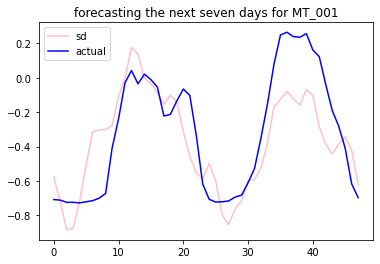

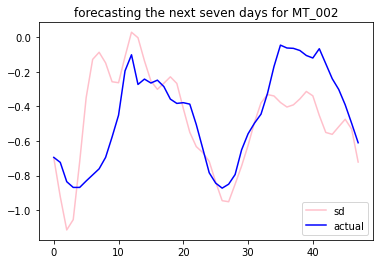

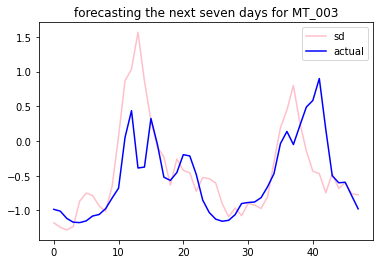

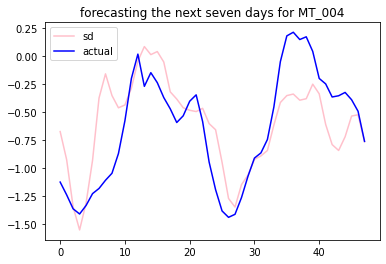

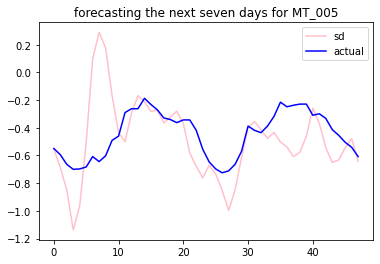

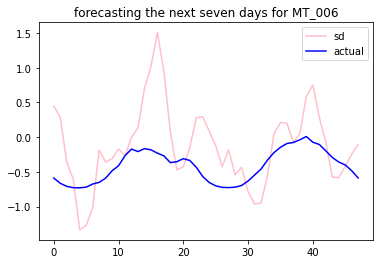

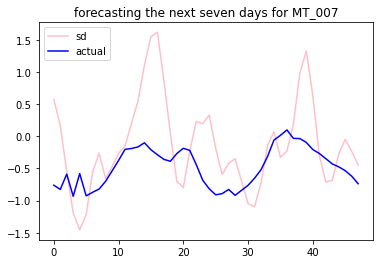

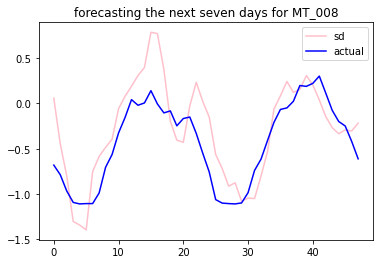

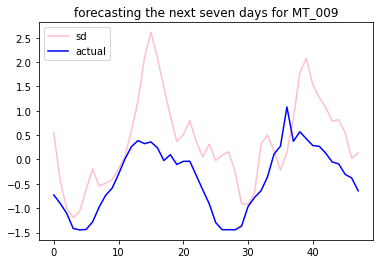

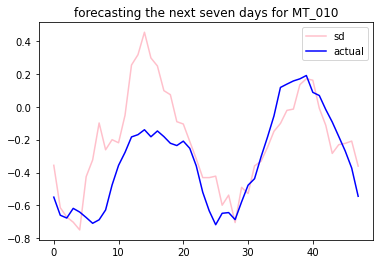

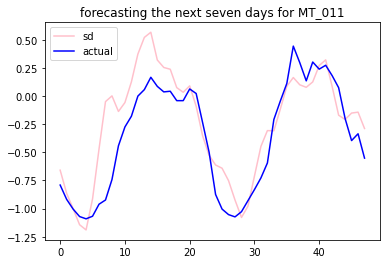

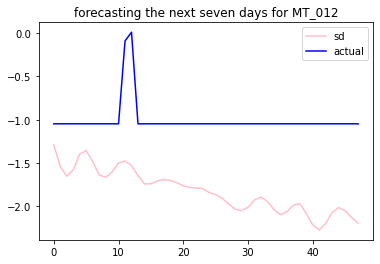

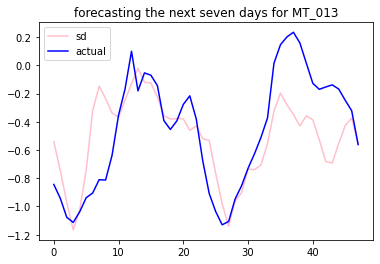

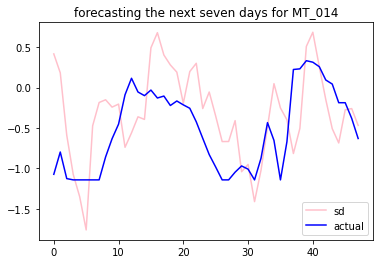

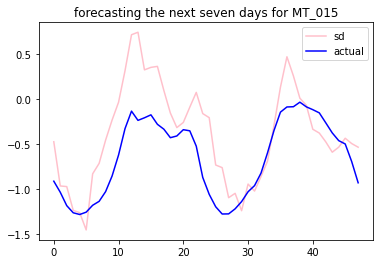

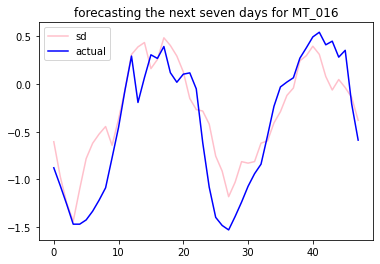

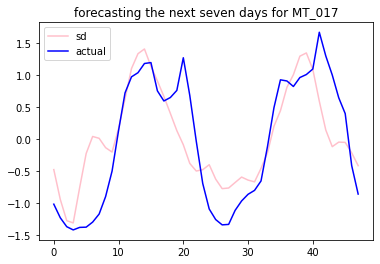

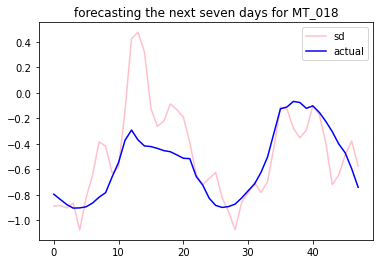

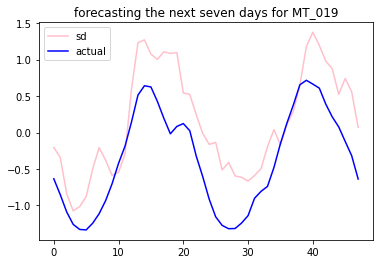

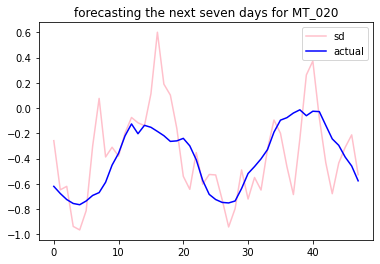

In [139]:
for dim in [1]:
    Y1, Y_sd, weights_sd, lst_U_sd = test_sd(data_train, data_test, L=80, n_users=20, M_ts=window, dim=dim, days=2, plot_all=True)



8
(17376, 20)
Forecasting accuracy (RMSE): 0.40418950902374207


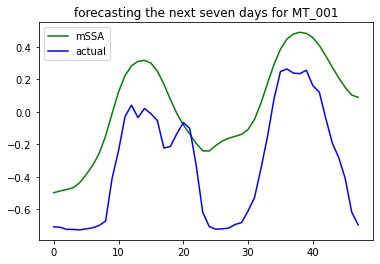

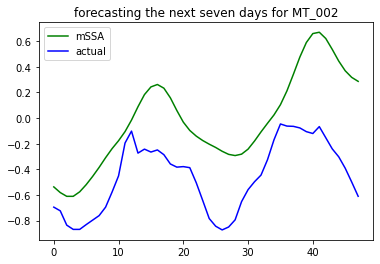

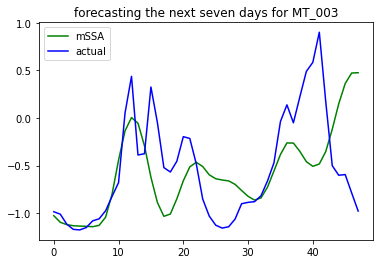

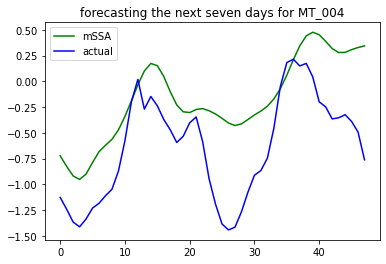

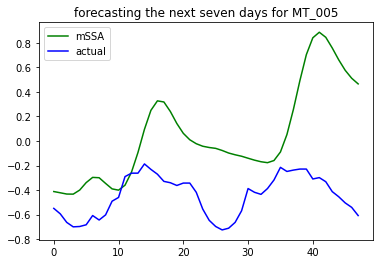

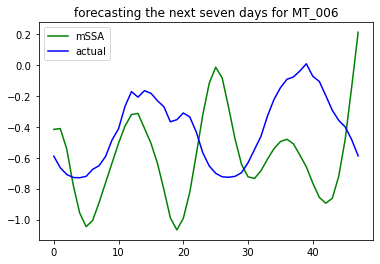

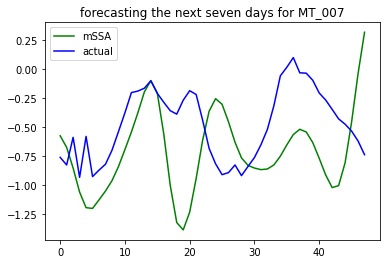

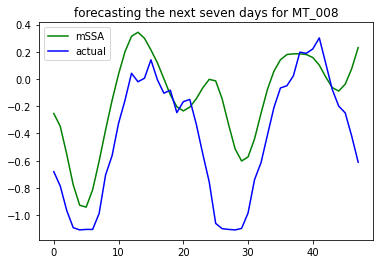

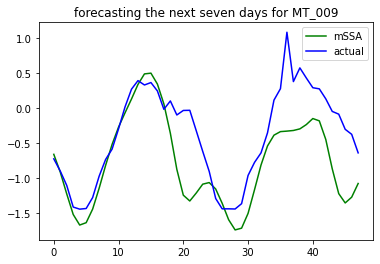

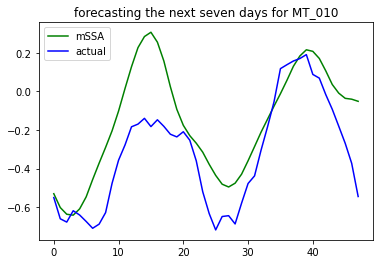

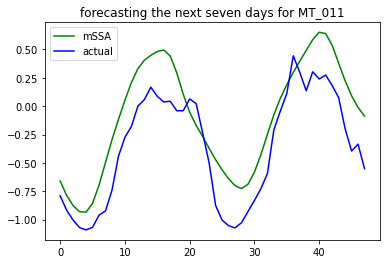

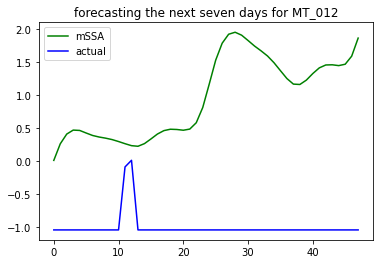

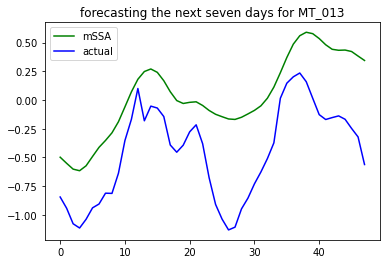

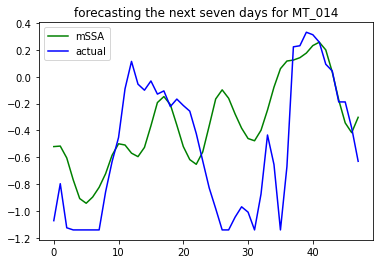

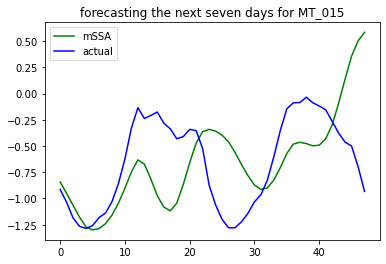

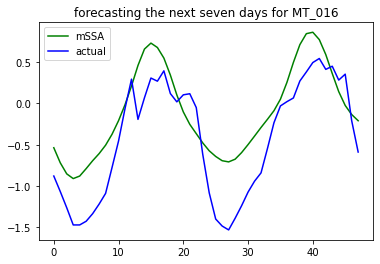

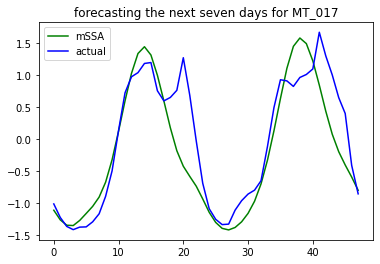

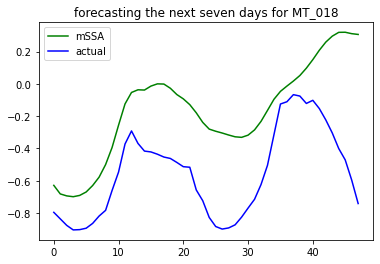

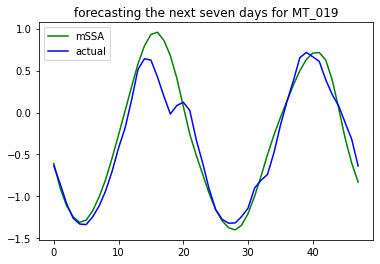

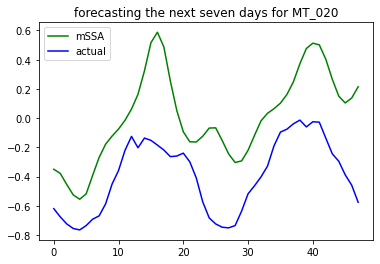

In [140]:
for rank in [8]:
    print(rank)
    Y2, Y_mssa, weights_mssa = test_mssa(data_train, data_test, rank=rank, L=80, n_users=20, days=2, plot_all=True)



15
(17376, 20)
imputation score 0.41272613044866785
Forecasting accuracy (RMSE) my: 0.5435056288712978


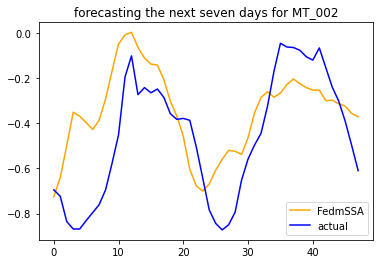

In [150]:
for dim in [15]:
    print(dim)
    Y3, Y_my, weights_my, lst_U_my = test_my(data_train, data_test, L=80, n_users=20, M_ts=window, dim=dim, days=2, plot_all=False)

imputation score: 0.4692460160795524
Forecasting accuracy (RMSE) my: 0.40509614926723114


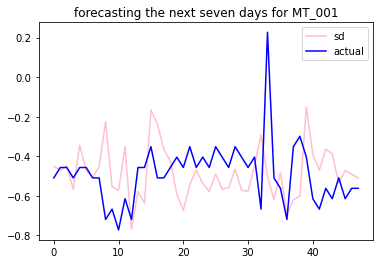

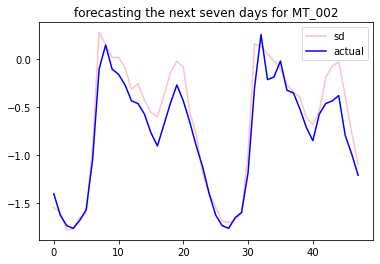

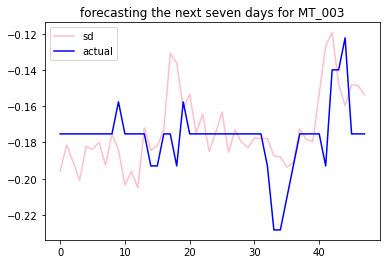

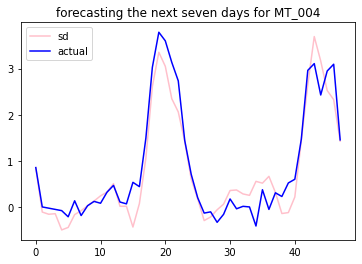

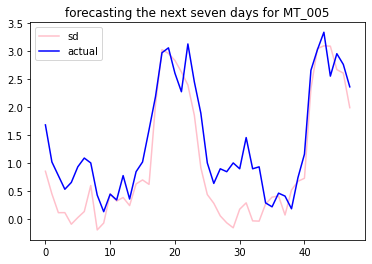

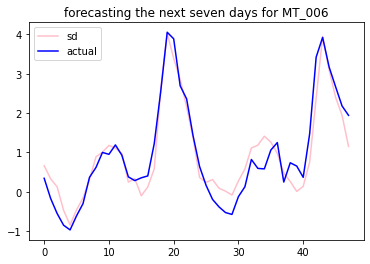

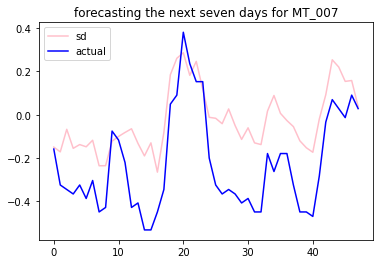

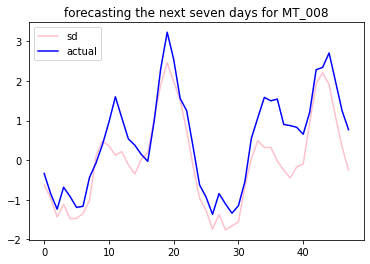

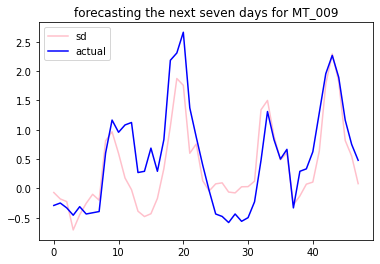

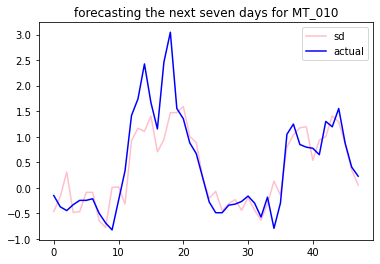

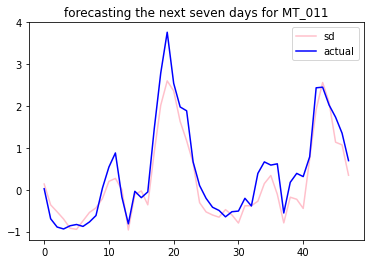

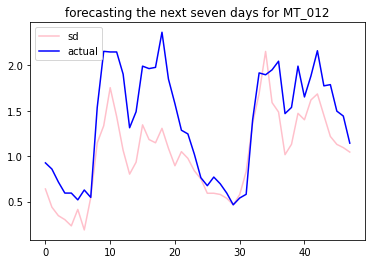

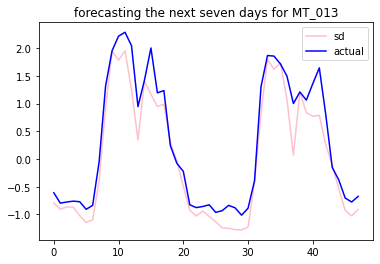

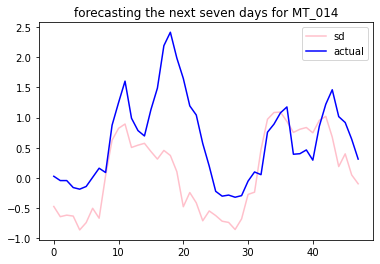

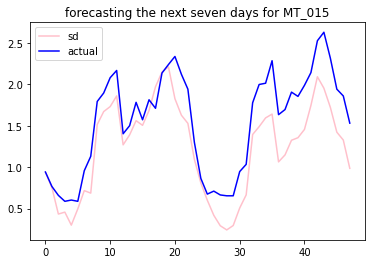

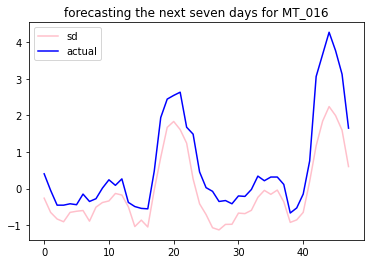

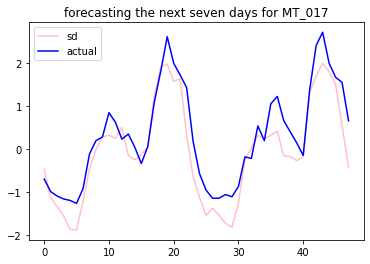

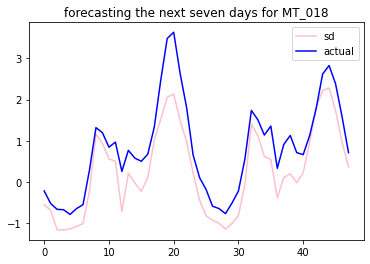

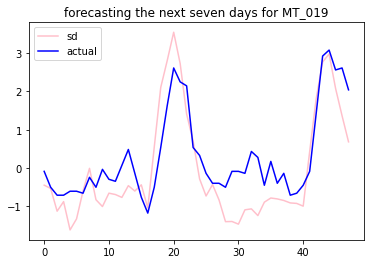

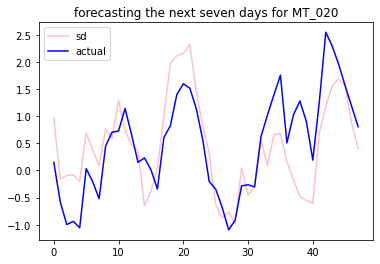

imputation score: 0.9712392078891096
Forecasting accuracy (RMSE) my: 0.32256028739399883


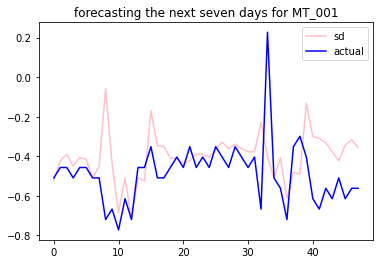

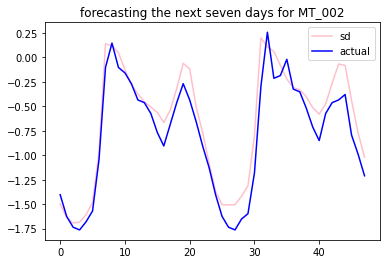

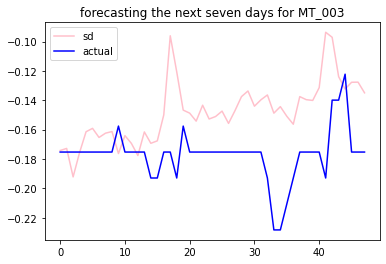

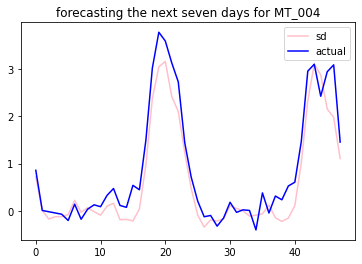

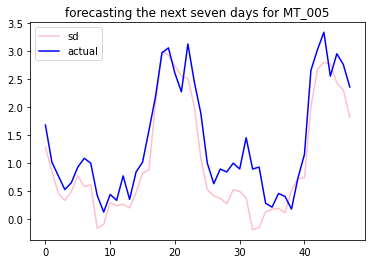

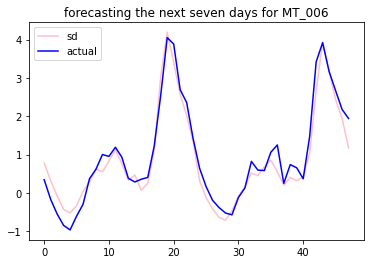

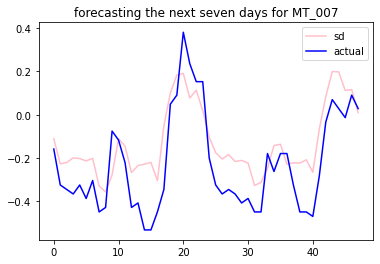

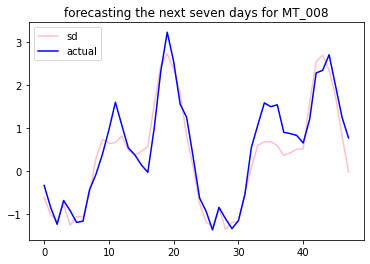

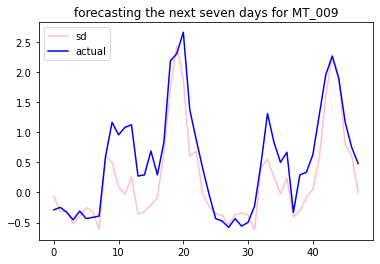

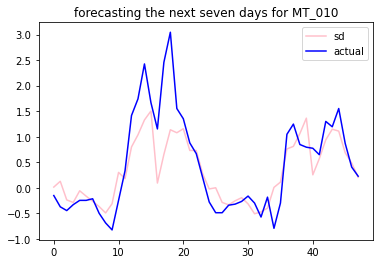

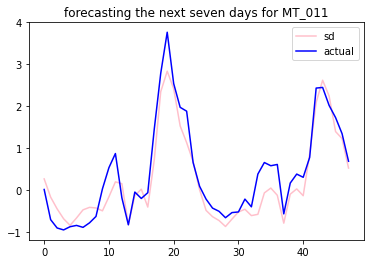

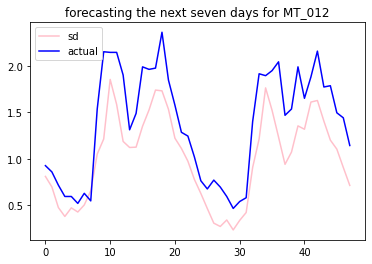

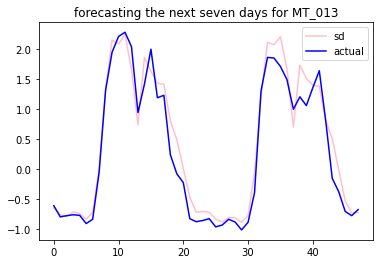

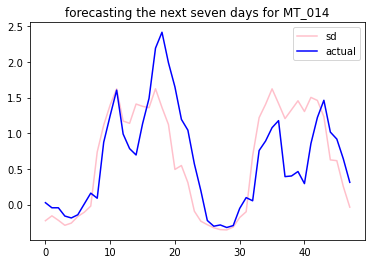

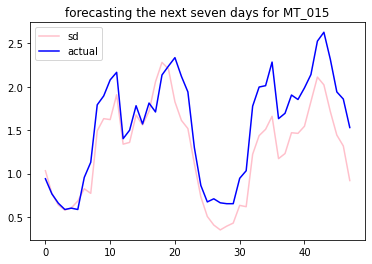

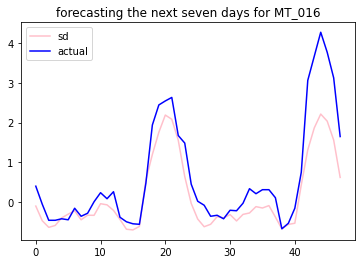

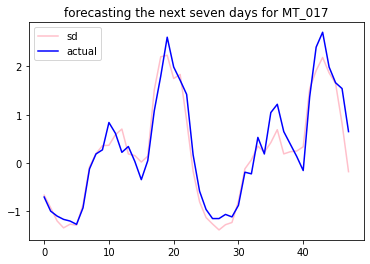

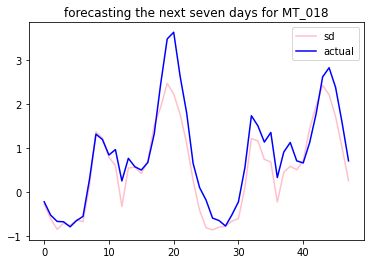

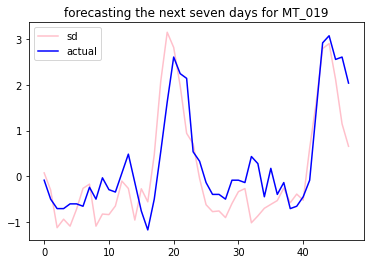

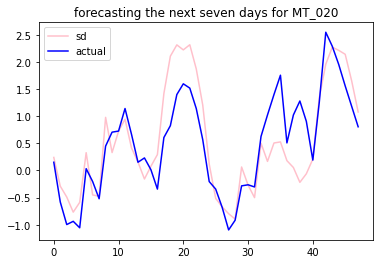

In [435]:
for dim in [1,15]:
    Y1, Y_sd, weights_sd, lst_U_sd = test_sd(data_train, data_test, L=80, n_users=370, M_ts=window, dim=dim, days=2, plot_all=True)


Forecasting accuracy (RMSE): 0.39356666523846906


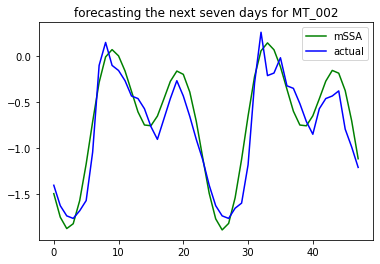

Forecasting accuracy (RMSE): 0.35624117952349776


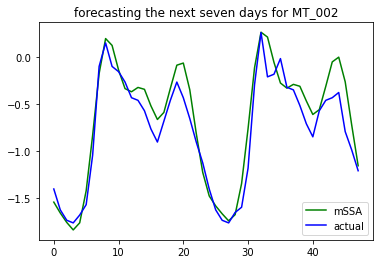

Forecasting accuracy (RMSE): 0.4646113085076256


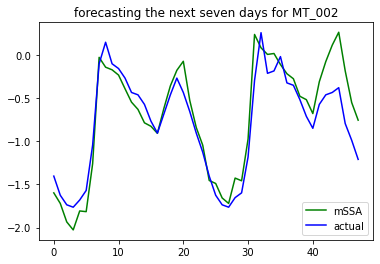

Forecasting accuracy (RMSE): 0.4139873642299547


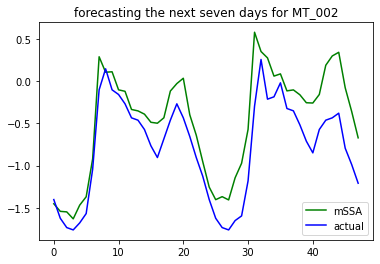

Forecasting accuracy (RMSE): 0.45419295129383375


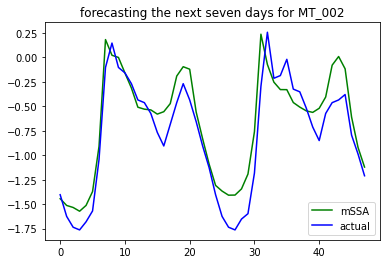

Forecasting accuracy (RMSE): 0.5715190263034948


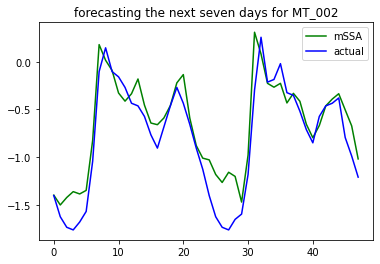

Forecasting accuracy (RMSE): 3.902468081009561


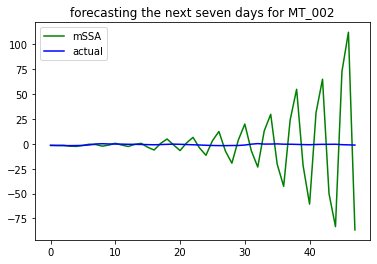

Forecasting accuracy (RMSE): 727.0672473434777


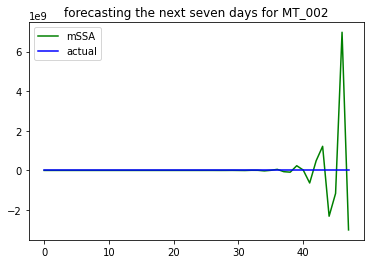

In [458]:
for rank in [5,15,30,40,50,60,70,79]:
    Y2, Y_mssa, weights_mssa = test_mssa(data_train, data_test, rank=rank, L=80, n_users=370, days=2, plot_all=False)


imputation score 0.9786874149616156
Forecasting accuracy (RMSE) my: 0.7277962218406808


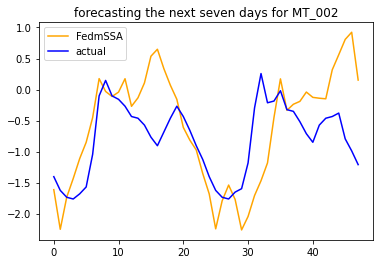

imputation score 0.9914118448673533
Forecasting accuracy (RMSE) my: 0.3389067404006437


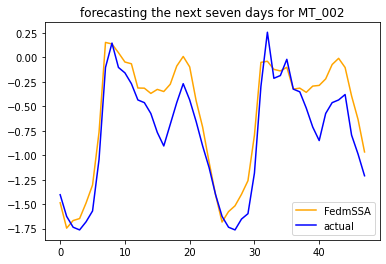

imputation score 0.9987409233386402
Forecasting accuracy (RMSE) my: 0.2978569794761263


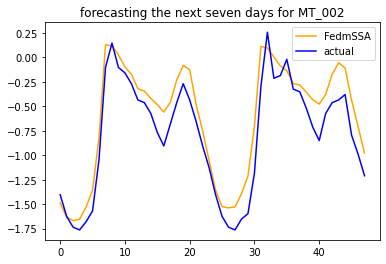

In [456]:
for dim in [70,75,79]:
    Y3, Y_my, weights_my, lst_U_my = test_my(data_train, data_test, L=80, n_users=370, M_ts=window, dim=dim, days=2, plot_all=False)


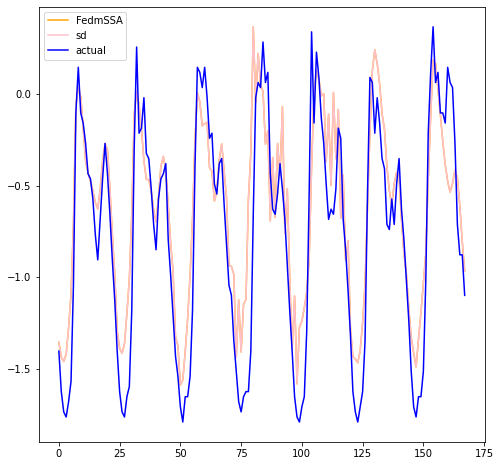

In [269]:
i=1
plt.figure(figsize=(8,8))
# plt.plot(Y_mssa[:24*7,i],label= 'mSSA',color='green')
plt.plot(Y_my[:24*7,i],label= 'FedmSSA',color='orange')
plt.plot(Y_sd[:24*7,i],label= 'sd',color='pink')
plt.plot(Y1[:24*7,i],label = 'actual',color='blue')
plt.legend()
plt.show()

In [270]:
all_pred = np.concatenate([Y_sd[:24*7,i].reshape(-1,1),Y_mssa[:24*7,i].reshape(-1,1),Y_my[:24*7,i].reshape(-1,1)], axis=1)

In [271]:
pd.DataFrame(all_pred)

,0,1,2
0,-1.355265,-12.881780,-1.355265
1,-1.436999,116.191503,-1.436999
2,-1.460852,-1163.718201,-1.460852
3,-1.421083,11357.034894,-1.421083
4,-1.277977,-110987.517987,-1.277977
...,...,...,...
163,-0.413965,-0.413965,-0.413965
164,-0.458218,-0.458218,-0.458218
165,-0.607726,-0.607726,-0.607726
166,-0.804372,-0.804372,-0.804372


imputation score 0.9308194348606641
Forecasting accuracy (RMSE) my: 5.699117748694025


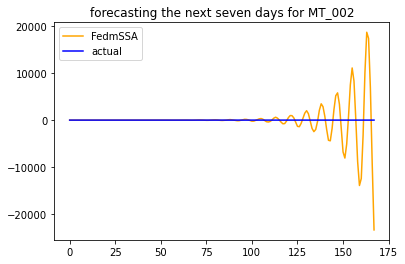

In [398]:
Y3, Y_my, weights_my, lst_U_my = test_my(data_train, data_test, L=80, n_users=20, M_ts=window, dim=60, days=7, plot_all=False)




In [206]:
Y_mssa.shape

(168, 20)

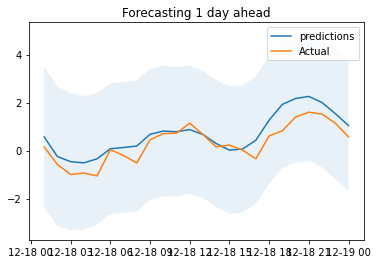

In [69]:
%matplotlib inline
df = model.predict('MT_020','2014-12-18 01:00:00','2014-12-19  00:00:00')


plt.figure()
plt.plot( df['Mean Predictions'], label = 'predictions')
plt.fill_between(df.index, df['Lower Bound'],df['Upper Bound'], alpha = 0.1)
plt.plot(data_test['MT_020'].iloc[:len(df['Mean Predictions'])], label = 'Actual', alpha = 1.0)
plt.title('Forecasting 1 day ahead')
plt.legend()
plt.show()



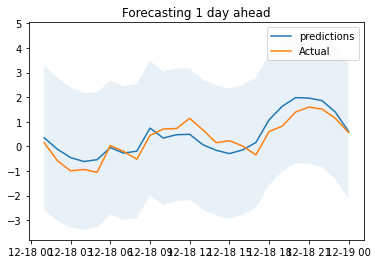

In [67]:
%matplotlib inline
df = model_my.predict('MT_020','2014-12-18 01:00:00','2014-12-19  00:00:00')


plt.figure()
plt.plot( df['Mean Predictions'], label = 'predictions')
plt.fill_between(df.index, df['Lower Bound'],df['Upper Bound'], alpha = 0.1)

# plt.plot(data_test['MT_020'].iloc[:len(df['Mean Predictions'])], label = 'Actual', alpha = 1.0)

# obtain new ground-true values by index of df
plt.plot(data_test['MT_020'][df.index], label = 'Actual', alpha = 1.0)
plt.title('Forecasting 1 day ahead')
plt.legend()
plt.show()



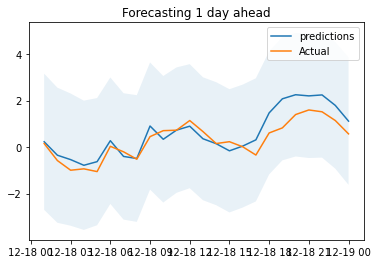

In [68]:
%matplotlib inline
df = model_sd.predict('MT_020','2014-12-18 01:00:00','2014-12-19  00:00:00')


plt.figure()
plt.plot( df['Mean Predictions'], label = 'predictions')
plt.fill_between(df.index, df['Lower Bound'],df['Upper Bound'], alpha = 0.1)

# plt.plot(data_test['MT_020'].iloc[:len(df['Mean Predictions'])], label = 'Actual', alpha = 1.0)

# obtain new ground-true values by index of df
plt.plot(data_test['MT_020'][df.index], label = 'Actual', alpha = 1.0)
plt.title('Forecasting 1 day ahead')
plt.legend()
plt.show()




Note that the confidence used to produce the prediction interval can be changed by the user. For example, we can produce the predictions with a 99.9% confidence using the `confidence` parameter of the `predict` function.

### Forecast hourly data for all houses for the next seven days

Now, we will do a more quanitative test by forecasting the next seven days using a rolling window approach. Specifically, we will forecast the next seven days one day at a time for all 20 houses. **Note that between forecasts, we will incrementally train the on the already predicted timeframe.** 


In [104]:
def predict_one_day(data_test, model, weights):

    #initialise prediction array
    predictions = np.zeros((len(data_test.columns),24*7))
    ub = np.zeros((len(data_test.columns),24*7))
    lb = np.zeros((len(data_test.columns),24*7))

    # specify start time
    start_time = pd.Timestamp('2016-12-25 00:00:00')

    # actual = data_test.values[:24*7,:]

    # obtain new actual by index, new test start from 2014-12-02-17:00
    actual = data_test[data_test.index>=start_time].values[:24*7,:]

    # predict for seven days
    days = 7

    for day in range(days):
        # get the final time stamp in the day
        end_time = start_time + pd.Timedelta(hours=23)
        # convert timestamps to string
        start_str = start_time.strftime('%Y-%m-%d %H:%M:%S')
        end_str = end_time.strftime('%Y-%m-%d %H:%M:%S')
        # predict for each house
        for i, column in enumerate(data_test.columns):
            # Forecast
            df_30 = model.predict(column,start_str,end_str)
            predictions[i,day*24:(day+1)*24] = df_30['Mean Predictions']
            ub[i,day*24:(day+1)*24] = df_30['Upper Bound']
            lb[i,day*24:(day+1)*24] = df_30['Lower Bound']

        # fit the model with the already predicted values 

    #     df_insert = data_test.iloc[day*24:24*(day+1),:]

        # obtain new df_insert
        df_insert = data_test[data_test.index>=start_time].iloc[day*24:24*(day+1),:]

#         model.update_model(df_insert)
    
        if weights is not None:
            model.ts_model.models[0].weights = weights

        # update start_time
        start_time = start_time + pd.Timedelta(hours=24)
    return actual, predictions

In [126]:
day = 0
start_time = pd.Timestamp('2014-12-18 01:00:00')
df_insert = data_test[data_test.index>=start_time].iloc[day*24:24*(day+1),:]
df_insert.index[-1]

Timestamp('2014-12-19 00:00:00')

In [129]:
actual, predictions = predict_one_day(data_test, model, None)
actual, predictions_my = predict_one_day(data_test, model_my, weights_LR)
actual, predictions_sd = predict_one_day(data_test, model_sd, weights_sd)


IndexError: index -1 is out of bounds for axis 0 with size 0

In [124]:
Y = actual[:,:]
Y_h = predictions.T[:,:]
Y_h_my = predictions_my.T[:,:]
Y_h_sd = predictions_sd.T[:,:]
mse = np.sqrt(np.mean(np.square(Y-Y_h)))
mse_my = np.sqrt(np.mean(np.square(Y-Y_h_my)))
mse_sd = np.sqrt(np.mean(np.square(Y-Y_h_sd)))
print ('Forecasting accuracy (RMSE):',mse)
print ('Forecasting accuracy (RMSE) my:',mse_my)
print ('Forecasting accuracy (RMSE) sd:',mse_sd)

Forecasting accuracy (RMSE): 0.5275554051657483
Forecasting accuracy (RMSE) my: 0.6784243626122183
Forecasting accuracy (RMSE) sd: 1.382974299944381


Let's calculate the error using the Root Mean Squared Error 


Now, let's inspect our forecasts visually for all the 20 time series

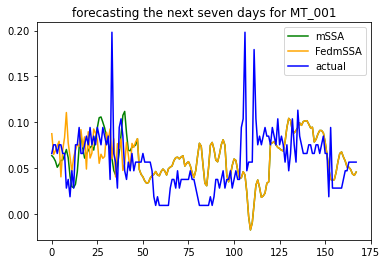

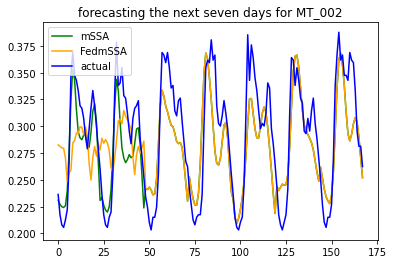

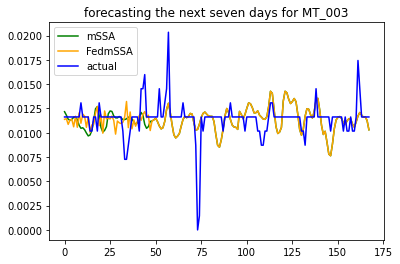

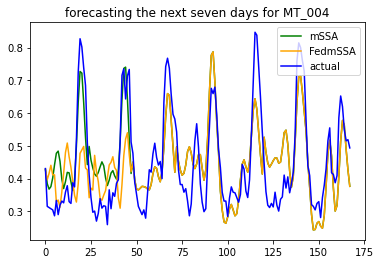

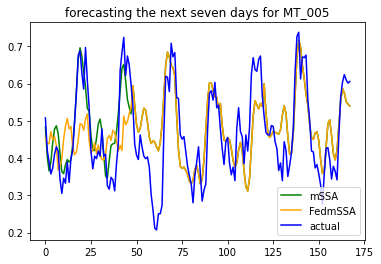

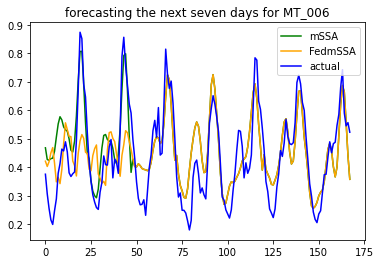

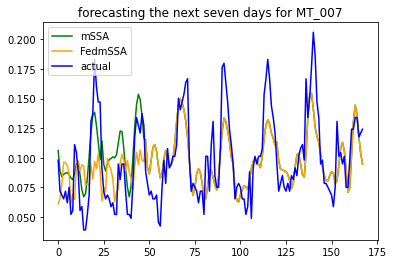

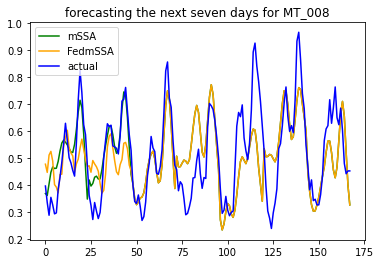

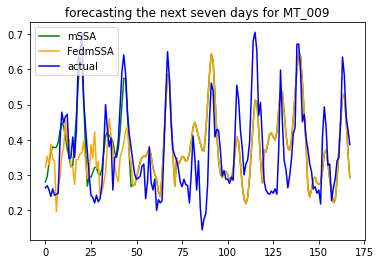

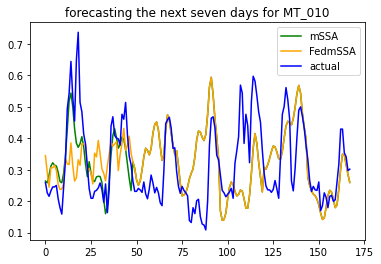

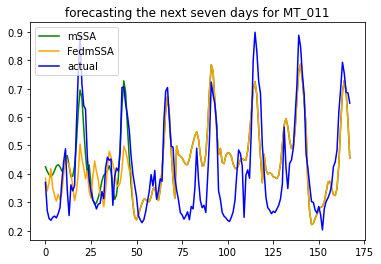

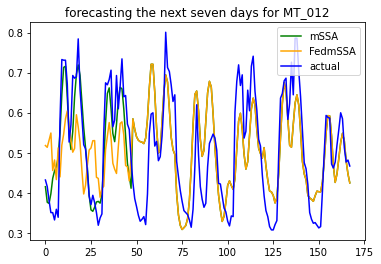

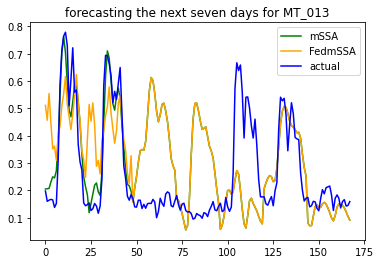

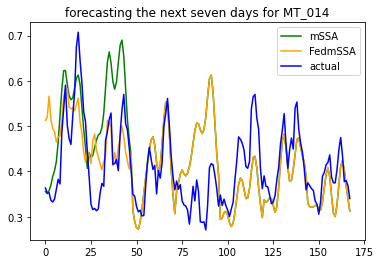

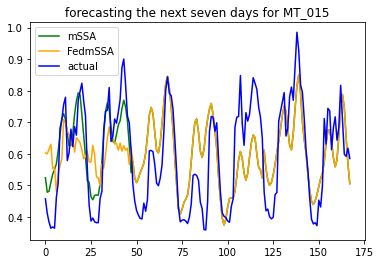

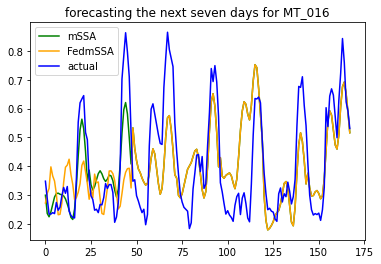

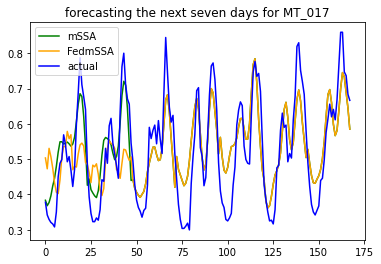

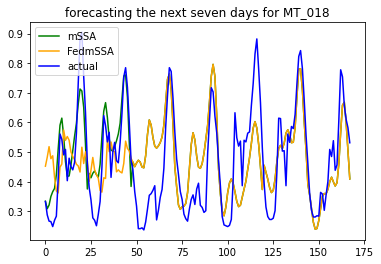

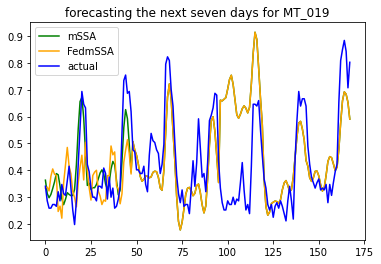

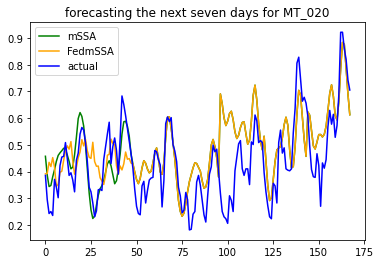

In [520]:
%matplotlib inline
for i in range(20):
    plt.figure()
    plt.title('forecasting the next seven days for %s'%data_test.columns[i])
    plt.plot(predictions[i,:24*7],label= 'mSSA',color='green')
#     plt.plot(predictions_my[i,:24*7],label= 'FedmSSA',color='orange')
#     plt.plot(predictions_sd[i,:24*7],label= 'sd',color='pink')
#     plt.fill_between(np.arange(24*7), lb[i,:24*7], ub[i,:24*7], alpha = 0.1)
    plt.plot(actual[:24*7,i],label = 'actual',color='blue')
    plt.legend()
plt.show()

### Aggregating with mSSA

This implementation allows you to pick an aggregating period (e.g. 1 hour, 2 hours, or 1 Day) and an aggregating function (from `average`, `min`,`max`) to preprocess your time series before fitting the model. 

For example, assume that instead of forecasting/imputing the hourly demand, we want to do it on a 2-hours interval. the `agg_period` and the `agg_method` option allow you to do that. 

In [358]:
# Specify the aggregation interval as two hours in seconds
model = mSSA(rank =20, agg_interval = 60*60*2 , agg_method = 'average')
# model
model.update_model(data_train)

In [348]:
# The predict function will now give a (2-hour)ly predictions
%matplotlib inline
df = model.predict('MT_020','2014-12-17 01:00:00','2014-12-19  00:00:00')


df


,Mean Predictions,Lower Bound,Upper Bound
2014-12-17 02:00:00,42.184440,31.965802,52.403077
2014-12-17 04:00:00,35.177277,25.132816,45.221738
2014-12-17 06:00:00,37.588586,27.549162,47.628010
2014-12-17 08:00:00,41.354047,31.381770,51.326324
2014-12-17 10:00:00,43.609705,33.560617,53.658793
2014-12-17 12:00:00,46.388316,36.261393,56.515238
2014-12-17 14:00:00,47.265337,37.186519,57.344155
2014-12-17 16:00:00,44.047373,33.855438,54.239307
2014-12-17 18:00:00,51.794032,41.613216,61.974848
2014-12-17 20:00:00,66.071977,55.788716,76.355238


In [95]:
def generate_synthetic_data_gaussian(id=0):
    np.random.seed(id)
    a = np.random.normal(size=(1000,3))
#     X = torch.Tensor(a.T)
    X = a.T
    # Xt = X.T
    return X
a = generate_synthetic_data_gaussian(id=0)
b = generate_synthetic_data_gaussian(id=1)
ab = np.concatenate([a,b], axis=1)
ab_tensor = torch.tensor(ab, dtype=torch.float64)
u,s,vt = np.linalg.svd(a)
u_ab,_,_ = np.linalg.svd(ab)

In [112]:
commonPCAz = np.load('/Users/this_mac/Library/CloudStorage/GoogleDrive-jewihogm@gmail.com/My Drive/Period 3 2021/Topics/Federated SVD/mSSA-master/electricity_train/commonPCAz.npy')
                         

In [114]:
u_admm = commonPCAz

In [107]:
ab.shape

(3, 2000)

In [53]:
a[:3,:3]

array([[ 1.76405235,  2.2408932 ,  0.95008842],
       [ 0.40015721,  1.86755799, -0.15135721],
       [ 0.97873798, -0.97727788, -0.10321885]])

In [ ]:
[[ 1.76405235  2.2408932   0.95008842]
 [ 0.40015721  1.86755799 -0.15135721]
 [ 0.97873798 -0.97727788 -0.10321885]]

In [45]:
b[:3,:3]

array([[ 1.62434536, -1.07296862,  1.74481176],
       [-0.61175641,  0.86540763, -0.7612069 ],
       [-0.52817175, -2.3015387 ,  0.3190391 ]])

In [46]:
u

array([[ 0.13844447, -0.3267705 , -0.93490864],
       [-0.97511144,  0.12009433, -0.18637337],
       [ 0.17317854,  0.93744248, -0.30201125]])

In [89]:
import torch
atensor = torch.tensor(a, dtype=torch.float64)
btensor = torch.tensor(b, dtype=torch.float64)
abt1 = torch.matmul(atensor,btensor.T).detach()
abt2 = a.dot(b.T)

In [116]:
u_admm

array([[-0.5137657 , -0.29274475, -0.80643991],
       [-0.79716558, -0.1845694 ,  0.57485753],
       [-0.31713065,  0.93820821, -0.13854061]])

In [96]:
u_admm = np.array([[-0.5137657,  -0.29274475 ,-0.80643991],
 [-0.79716558, -0.1845694 ,  0.57485753],
 [-0.31713065  ,0.93820821, -0.13854061]])
u_admm_tensor = torch.tensor(u_admm, dtype=torch.float64)

In [48]:
u_admm1  = np.array( [[-0.75283769 ,-0.25358273, -0.60739708],
 [-0.54990134, -0.26482142 ,0.79213517],
 [-0.36172356,  0.93035768 , 0.05992206]])

u_admm2 = np.array(  [[-0.50987315, -0.28795568, -0.81062377],
 [-0.80153018 ,-0.18315224 , 0.56921405],
 [-0.31237598 , 0.93996637, -0.13742076]])

In [49]:
np.allclose((u_admm.T.dot(u_admm) - np.eye(3)), np.zeros(3))

True

In [97]:
def re_error(u, X):
    Xhat = u.dot(u.T.dot(X))
#     print("Xhat.shape = ", Xhat.shape)
    re_error = np.linalg.norm(X-Xhat)
#     return np.sqrt(((u.dot(u.T.dot(X)) - X)**2).sum())
    return re_error

In [101]:
def re_error_tensor(u,X):
    residual = torch.matmul((torch.eye(u.shape[0]) - torch.matmul(u, u.T)), X.to(torch.float64))
    loss_train = torch.norm(residual, p="fro")
    return loss_train

In [102]:
re_error_tensor(u_admm_tensor, ab_tensor)

tensor(5.9435e-07, dtype=torch.float64)

In [115]:
print(re_error(u, a))
print(re_error(u_ab, ab))
print(re_error(u_admm, ab))
print(re_error(u_admm1, a))
print(re_error(u_admm2, b))

2.6334943530740565e-14
4.6658752258116655e-14
4.939163116852094e-14
2.9846128413473926e-07
4.4331529344573335e-07


In [ ]:
# ADMMM: imputation_model_score

Uk_admm = np.load('/Users/this_mac/Library/CloudStorage/GoogleDrive-jewihogm@gmail.com/My Drive/Period 3 2021/Topics/Federated SVD/mSSA-master/electricity_train/Grassmann_ADMM_Electricity_20_L20_d50_imputation.npy')


In [374]:
import h5py
filename = '/Users/this_mac/Library/CloudStorage/GoogleDrive-jewihogm@gmail.com/My Drive/Period 3 2021/Topics/Federated SVD/mSSA-master/electricity_train/Grassmann_ADMM_Electricity_2_L20_d3_imputation.h5'

lst_U = []

with h5py.File(filename, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    # get first object name/key; may or may NOT be a group
    for a_group_key in list(f.keys()):
        ds_arr = f[a_group_key][()]  # returns as a numpy array
        lst_U.append(ds_arr)

Keys: <KeysViewHDF5 ['0', '1']>


In [384]:
print(re_error(u, a))
print(re_error(u_ab, ab))
print(re_error(lst_U[0], a))
print(re_error(lst_U[1], b))

2.6334943530740565e-14
4.6658752258116655e-14
1.0500288224455469e-14
1.3832432421115063e-14


In [385]:
aa = re_error(lst_U[0], a)**2
bb = re_error(lst_U[1], a)**2
np.sqrt((aa+bb))

1.7002391192612102e-14